# Simulationen mit Delphi

In diesem Jupyter Notebook sollen die Simulationen des Delphi Modells durchgeführt werden. Das Delphi Modell selbst ist in der Datei Delphi.py implementiert. Zunächst werden hier verschiedene Funktionen implementiert, die für die Generierung der Daten, Transformation der Daten in ein Delphi-Format, Training und Auswertung eines Delphi Modells zuständig sind.

### Laden wichtiger Bibliotheken

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import tqdm # Für Ladebalken
from Delphi import Delphi
import matplotlib.pyplot as plt

## Datengenerierung für Delphi

Hier sollen nun Daten generiert werden. Dabei erfolgt die Datengenerierung gemäß Abschnitt 2.2. Zunächst werden hier Parameter eines wahren Modells bestimmt und anhand dieses wahren Modells können Übergangszeiten generiert werden. Dabei ist für das Training der Delphi-Modelle nur die Zeitdifferenz zwischen den Übergängen von Bedeutung, sodass hier die Differenzen gebildet werden. Hier zeigt sich, dass das Training wesentlich stabiler ist, wenn die Größenordnung der Zeitdifferenzen angeglichen wird, dabei wird hier durch die durchschnittliche Potenz geteilt, sodass die Daten einigermaßen von der gleichen Größenordnung sind.

In [2]:
def generate_data(n_patients, m, n):
    # Generiert die Daten gemäß Abschnitt 2.2
    # Parameter:
    # n_patients: Anzahl der Patienten
    # m: Anzahl Covariate
    # n: Anzahl Zustände
    # Rückgabe:
    # Z: Covariatenmatrix (n_patients x m)
    # T: Matrix mit den Übergangszeiten (n_patients x (n - 1))
    # dT: Matrix mit den Zeitdifferenzen (für Delphi), reduziert durch die durchschnittlichen Potenzen
    # average_potency: durchschnittliche Potenzen der Zeitdifferenzen

    # Definiere marginale Wahrscheinlichkeiten der Covariaten
    p_k = np.random.uniform(0.05, 0.3, m)

    #Erzeugung der Covariatenmatrix Z
    Z = []
    for i in range(n_patients):
        Z.append(np.random.binomial(1, p_k))
    Z = np.array(Z) # jede Zeile steht für einen Patienten

    # Generierung der Werte von beta (jede Zeile stellt einen Übergang dar)
    beta_matrix = np.sqrt(10 / m) * np.random.normal(0, 0.65, size=(n - 1, m)) 

    # Generierung der Werte von b
    b_1 = 1
    epsilon = 0.001
    b_values = [b_1]
    for j in range(1, n - 1):
        beta = beta_matrix[j]
        y = (beta < 0)
        y_hat = (beta > 0)

        factor = np.exp(- beta @ y_hat)
        min_factor = []
        for i in range(0, j):
            beta_i = beta_matrix[i]
            min_factor.append(b_values[i] * np.exp(beta_i @ (beta_i < 0)))
        b_values.append(np.min(min_factor) * factor * epsilon / (1 - epsilon))

    # Erzeugung der Übergangszeiten
    T = []
    for i in range(n - 1):
        T_i = np.random.exponential(1/(b_values[i] * np.exp(Z @ beta_matrix[i])))
        T.append(T_i)
    T = np.array(T).transpose() # jede Zeile steht für einen Patienten

    # Wir sind nur an den Zeitdifferenzen interessiert
    dT = T.copy()
    for i in range(1, n-1):
        dT[:, i] = dT[:, i] - dT[:, i - 1]

    # Problematisch ist, dass die Zeiten sich über sehr viele 10er Potenzen erstrecken, was ein Training schwieriger macht
    # Deshalb wird hier die Potenz der Zeiten künstlich reduziert, indem wir durch die durchschnittliche Potenz einer Spalte von T teilen:
    average_potency = np.floor(np.log10(np.mean(T, axis=0)))
    dT = dT / 10**average_potency

    return Z, T, dT, average_potency

### Formatierung der Daten ins Delphi Format

Nun müssen die Daten noch in ein Delphi-konformes Format gebracht werden. Dazu werden die Zustände und Covariaten wie im Abschnitt zum Token Embedding in One-hot codierte Vektoren transformiert.

In [3]:
def transform_to_delphi(Z, dT, n_patients, m, n):
    # Transformiert die Daten ins Delphi Format
    # Parameter:
    # Z: Covariatenmatrix (n_patients x m)
    # dT: Matrix mit den Zeitdifferenzen (für Delphi), reduziert durch die durchschnittlichen Potenzen
    # n_patients: Anzahl der Patienten
    # m: Anzahl Covariate
    # n: Anzahl Zustände
    # Rückgabe:
    # patient_id: numpy array mit den Patienten IDs
    # X_data: Daten im Delphi Format (Liste an Torch Tensoren)
    # y_targets: Liste an numpy arrays mit dem nächsten Delphi Zustand
    # T_targets: torch Tensor mit den Zeiten zum nächsten Event

    patient_id = []
    X_data = []
    y_targets = []
    T_targets = []
    onehot_classes = n + m

    for i in tqdm.trange(n_patients, desc='Transforming Data'):
        x = np.concatenate((Z[i], np.zeros(n))) # covariates + states
        dt = dT[i] 
        for j in range(n - 1):
            patient_id.append(i + 1)
            x[m + j] = 1 # we achieve state j + 1 (start by j = 0)
            active_states = np.where(x==1)[0] # numbers of active states (starting by 0)

            # start one_hot encoding
            X = np.eye(onehot_classes)[active_states]
            X_data.append(torch.FloatTensor(X))

            # save the targets
            y = np.zeros(n + m)
            y[m + j + 1] = 1 # the next state is j + 2 (start by j = 0)
            y_targets.append(y)

            T_targets.append(dt[j]) #save the time to the next event    

    patient_id = np.array(patient_id)
    T_targets = torch.tensor(T_targets)

    return patient_id, X_data, y_targets, T_targets

# Training des Delphi Modells

Hier soll nun der eigentliche Trainingsblock des Delphi Modells implementiert werden. Dazu wird das Modell für mehrere Epochen trainiert, wobei wir die Trainingsdaten in Batches von 100 Patienten aufteilen. Für jeden Batch bestimmen wir dann den Cross-Entropy (ce) Loss und den Time-Loss, durch Optimierung des Gesamt-Loss wird das Modell optimiert. Die Funktion liefert eine Liste mit den Loss-Werten während der Batches zurück, um den Trainingsfortschritt überprüfen zu können.

In [4]:
def train(model, X_data, y_targets, T_targets, n_train, n, epochs=100, learning_rate=1e-6, verbose=False, mu = 1e-3, leave=True):
    # Trainingsblock für das Delphi Modell
    # Parameter:
    # model: Delphi Modell zum Optimieren
    # X_data: Daten im Delphi Format (Liste an Torch Tensoren)
    # y_targets: Liste an numpy arrays mit dem nächsten Delphi Zustand
    # T_targets: torch Tensor mit den Zeiten zum nächsten Event
    # n_train: Definiert wieviele Patienten der Trainingsdaten fürs Training verwendet werden sollen,
    # Hier wird festgelegt, wieviele Daten verwendet werden sollen. (n_train soll durch 100 Teilbar sein).
    # n: Anzahl der Zustände
    # epochs: Anzahl der Epochen zum Trainieren
    # learning_rate: learning_rate
    # verbose: Falls True, wird der Loss nach jedem Batch ausgegeben
    # mu: positiver Gewichtungsfaktor der Losses
    # leave: Falls True, bleibt der Ladebalken sichtbar

    # Rückgabe:
    # ce_losses: Liste mit den Cross-Entropy Loss Werten nach jedem Batch
    # time_losses: Liste mit den Time Loss Werten nach jedem Batch
    
    # define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # lists to restore loss values
    ce_losses = []
    time_losses = []
    
    # training loop
    for epoch in tqdm.trange(epochs, desc='Training Delphi Model', leave=leave):

        # split the data into batches of 100 patients
        for i in range(n_train // 100):
            ce_loss = 0
            time_loss = 0
            # we want to use the data of 100 patients, each patients has n_states - 1 data
            # matrices so we get an index range:
            for j in range(100 * (n - 1) * i , 100 * (n - 1) * (i + 1)):
                # get the prediction
                y_prediction, t_prediction, rate = model(X_data[j])
                y_target = y_targets[j]
                t_target = T_targets[j]

                # calculate the losses
                ce_loss += -torch.log(y_prediction[y_target == 1])
                time_loss += - (torch.log(rate) - rate * t_target)
            # get the whole loss
            loss = ce_loss + time_loss * mu
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # restore loss values
            ce_losses.append(ce_loss.item())
            time_losses.append(time_loss.item())

            if verbose:
                print("Loss: ", loss)
    return ce_losses, time_losses

In [5]:
# Funktion um die Anzahl der Parameter eines Delphi Modells auszugeben
def get_number_of_parameters(D, n_embd):
        return (2*D + 11)*n_embd + 11 * n_embd**2 + D

## Auswertung des Delphi Modells
Hier soll nun eine Funktion definiert werden, welche das Delphi Modell auswertet. Hierzu werden Daten, welche nicht Teil des Trainings waren, in das Modell eingesetzt. Dabei soll die Funktion zwei Matrizen zurückgeben. Zum einen eine Matrix die den Zeitfehler für jeden Patienten und jeden Übergang beschreibt, zum anderen eine Matrix die für jeden Patienten und jeden Zustand die Wahrscheinlichkeit des nächsten Wahren Zustands angibt.

In [6]:
def validate(model, X_data, y_targets, T_targets, n_validate, n, m, patient_id):
    # Trainingsblock für das Delphi Modell
    # Parameter:
    # model: Delphi Modell zum Auswerten
    # X_data: Daten im Delphi Format (Liste an Torch Tensoren)
    # y_targets: Liste an numpy arrays mit dem nächsten Delphi Zustand
    # T_targets: torch Tensor mit den Zeiten zum nächsten Event
    # n_validate: Definiert an wievielen Patienten das Modell ausgewertet werden soll
    # n: Anzahl der Zustände
    # m: Anzahl der Covariate
    # patient_id: ID der Patienten

    # Rückgabe:
    # time_errors: Matrix der Größe n_validate x (n - 1) mit den absoluten Zeitfehlern
    # y_errors: Matrix der Größe n_validate x (n - 1) mit den Wkt des wahren nächsten Zustandes
    time_errors = torch.zeros(n_validate, n - 1)
    y_errors = torch.zeros(n_validate, n - 1)

    # Wir berechnen die Daten für jeden Patienten, wir beginnen dabei am Ende der Matrix X_data
    for i in range(1, n_validate * (n - 1)):
        # get the prediction
        y_prediction, t_prediction, rate = model(X_data[-i])
        y_target = y_targets[-i]
        t_target = T_targets[-i]

        # get the position in the matrices
        actual_state = np.where(y_target == 1)[0].item() - m - 1
        actual_patient = patient_id[-1] - patient_id[-i]

        time_errors[actual_patient, actual_state] = t_target - t_prediction
        y_errors[actual_patient, actual_state] = y_prediction[y_target == 1]

    return time_errors, y_errors

## Training und Auswertung des Cox-Modells
Um das Delphi Modell mit dem anderen Schätzer vergleichen zu können, soll dieser hier ebenfalls implementiert werden. Die Auswertung soll genauso wie beim Delpi Modell erfolgen.

In [7]:
def fit_and_validate_cox(Z, T, n_train, n_validate):
    # Parameters:
    # Z: Covariatenmatrix (n_patients x m)
    # T: Matrix mit den Übergangszeiten (n_patients x (n - 1))
    # n_train: Anzahl der Patienten zum Trainieren
    # n_validate: Anzahl der Patienten zur Auswertung

    # Rückgabe:
    # beta_matrix: Matrix der Größe (n - 1) x m mit den Werten der berechneten Regressionsparametern beta
    # b_values: Array mit (n - 1) Elementen, den berechneten Werten von b
    # time_errors: Matrix der Größe n_validate x (n - 1) mit den absoluten Zeitfehlern

    # Fit des Cox Modells:
    beta_matrix = []
    b_values = []
    factor_matrix = 1 / np.var(Z[:n_train], axis = 0)
    x_mean = np.mean(Z[:n_train], axis = 0)
    n_states = T.shape[1]
    
    for transition in range(n_states):
        t = T[:n_train, transition]
        log_t = np.log(t)
        log_t_mean = np.mean(log_t)
        log_t_x_mean = np.mean(Z[:n_train] * log_t.reshape(-1, 1), axis=0)

        beta = factor_matrix * (log_t_mean * x_mean - log_t_x_mean)
        beta_matrix.append(beta)

        b = n_train / np.mean( np.exp(Z[:n_train] @ beta) * t)
        b_values.append(b)
        
    beta_matrix = np.array(beta_matrix)
    b_values = np.array(b_values)

    # Auswertung des Cox Modells
    time_errors = []
    for transition in range(n_states):
        t_target = T[-n_validate:, transition]

        beta = beta_matrix[transition]
        b = b_values[transition]
        rates = b * np.exp(Z[-n_validate:] @ beta)
        
        t_prediction = np.random.exponential(scale=1/rates)
        time_errors.append(t_target - t_prediction)

    # Transponieren von time_errors für die richtige Dimension
    time_errors = np.array(time_errors).transpose()

    return beta_matrix, b_values, time_errors

## Simulation
Hier erfolgt der eigentliche Block der Simulation. Hier empfiehlt es sich keine For-Schleife für mehrere Simulationen zu verwenden, da eventuell die learning-rate angepasst werden muss. Im folgenden sind für die Simulationen nur die Parameter anzupassen. Ausgabe ist immer ein Plot der Loss Kurven um den Trainingsfortschritt untersuchen zu können. Außerdem werden Zeitfehler des Delphi-Modells, des Cox Modells und die Übergangswahrscheinlichkeiten in den nächsten wahren Zustand des Delphi Modells ausgegeben.

Anzahl Parameter:  195


Training Delphi Model: 100%|███████████████████████████████████████████████████████████| 30/30 [02:19<00:00,  4.65s/it]


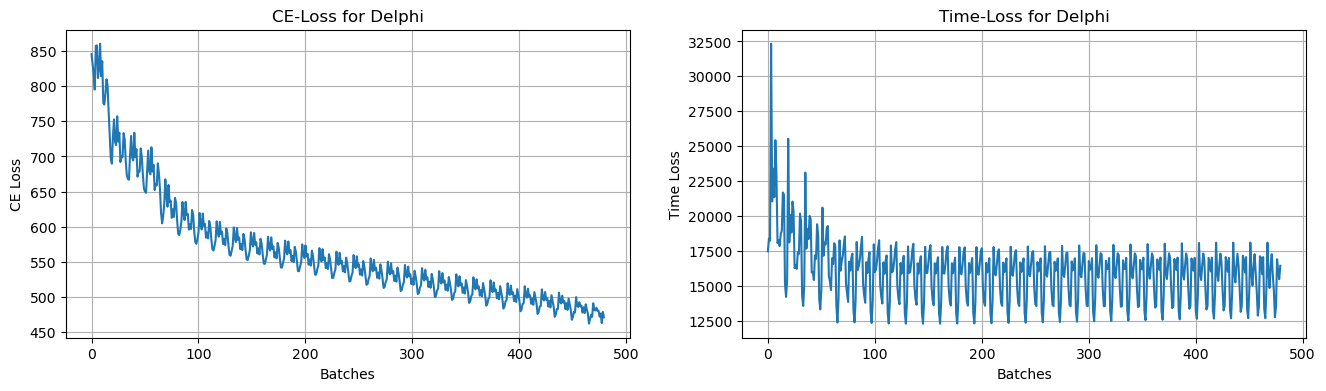

Delphi p:  [0.24461539 0.28323907 0.17374553]
Delphi dp:  [0.00174213 0.00117171 0.00119183]
Delphi t:  [9.302979 4.511447 1.406473]
Delphi dt:  [0.2063457  0.15694669 0.0293004 ]
Cox t:  [9.46219737 4.82315022 1.51139659]
Cox dt:  [0.20629268 0.15646632 0.02951057]


In [106]:
# wichtige Hyperparameter zum Einstellen der Simulation
n = 4 # Anzahl Zustände
m = 5 # Anzahl Covariaten
n_train = 1600
n_validate = 3000
n_patients = n_train + n_validate # Anzahl aller Patienten
#n_embd = n + m  # Für Simulation 1
n_embd = 3 # Für Simulation 2
epochs = 30

# Erzeugung des Delphi Modells
model = Delphi(n + m, n_embd)

print("Anzahl Parameter: ", get_number_of_parameters(n + m, n_embd))

# Generierung und Transformation der Daten
Z, T, dT, average_potency = generate_data(n_patients, m, n)
patient_id, X_data, y_targets, T_targets = transform_to_delphi(Z, dT, n_patients, m, n)

# Check ob die generierten Daten nicht negativ sind
if (np.sum(dT <= 0) != 0):
    print("Fehler bei der Datengenerierung")
    print(np.sum(dT <= 0))
    print(1/0)

# Training des Delphi Modells
ce_losses, time_losses = train(model, X_data, y_targets, T_targets, n_train, n, epochs=epochs)

# Plot Loss curves
file = "Loss_curves_Delphi_" + str(n) + "_states_" + str(m) + "_cov_" + str(n_embd) + "_embd_" + str(n_train) + "_patients.png"
fig = plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(ce_losses)
plt.title("CE-Loss for Delphi")
plt.xlabel("Batches")
plt.ylabel("CE Loss")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(time_losses)
plt.title("Time-Loss for Delphi")
plt.xlabel("Batches")
plt.ylabel("Time Loss")
plt.grid()

plt.savefig(file)
plt.show()

# Auswertung des Delphi Modells
time_errors, y_errors = validate(model, X_data, y_targets, T_targets, n_validate, n, m, patient_id)

p = torch.mean(y_errors, axis=0).detach().numpy() # Mittelwert der Wkts für jeden Zustand
dp = torch.var(y_errors, axis=0).detach().numpy() / n_validate # Varianz des Mittelwerts
dp = np.sqrt(dp)
t = torch.mean(torch.abs(time_errors), axis=0).detach().numpy() # Mittelwert der Zeitfehler für jeden Zustand
dt = torch.var(torch.abs(time_errors), axis=0).detach().numpy() / n_validate # Varianz des Mittelwerts
dt = np.sqrt(dt)
print("Delphi p: ", p)
print("Delphi dp: ", dp)
print("Delphi t: ", t)
print("Delphi dt: ", dt)

# Auswertung und Fit des Cox Modells
cox_beta_matrix, cox_b_values, cox_time_errors = fit_and_validate_cox(Z, dT, n_train, n_validate)
cox_t = np.mean(np.abs(cox_time_errors), axis=0) # Mittelwert der Zeitfehler für jeden Zustand
cox_dt = np.var(np.abs(cox_time_errors), axis=0) / n_validate # Varianz des Mittelwerts
cox_dt = np.sqrt(cox_dt)
print("Cox t: ", cox_t)
print("Cox dt: ", cox_dt)

## Simulation 1: Variation der Anzahl der Trainingssamples
In dieser Simulation soll der Einfluss der Anzahl der Trainingssamples untersucht werden. Simuliert wurde hier ein Modell mit n = 4 Zuständen, m = 5 Covariaten und n_embd = n + m. Trainiert wurde mit $\mu = 10^{-3}$ und einer Learning rate von $10^{-6}$. Das Delphi Modell hat hier insgesamt 1161 Parameter. Die Auswertung erfolgt hier jeweils durch 3000 Patienten, mit welchen nicht trainiert wurde.

In [57]:
# Speichern der Daten
n_samples = np.array([100, 500, 1000, 3000, 7000, 10000, 15000, 20000, 25000])
epochs = np.array([200, 100, 75, 50, 20, 15, 15, 15, 15])
p = [[0.31534705, 0.3263895,  0.5338324 ],
    [0.25947994, 0.5134061,  0.6326363 ],
    [0.3046232, 0.4126565, 0.5863306],
    [0.56174695, 0.56508857, 0.80901456],
    [0.45636246, 0.82249665, 0.80178255],
    [0.5703969, 0.6544434,  0.82366407],
    [0.6917988,  0.87920225, 0.8496708 ],
    [0.7063686,  0.82727116, 0.859334  ],
    [0.74110985, 0.90795356, 0.9391312 ]]

dp = [[0.00252527, 0.002312  , 0.00326792],
     [0.0015416 , 0.00218492, 0.00175706],
     [0.00183392, 0.00072319, 0.00140803],
     [0.00280327, 0.00126753, 0.00111064],
     [0.00341277, 0.00123357, 0.00115813],
     [0.00271867, 0.00205114, 0.00166761],
     [0.0030785,  0.00097056, 0.00090762],
     [0.00277018, 0.00098541, 0.00094527],
     [0.00287892, 0.00070115, 0.0003855 ]]

t = [[1.4492353, 2.935196,  1.9393854],
    [1.0720186,  0.98659337, 9.667548],
    [2.6200309, 2.8711598, 7.4960656],
    [2.771291,  1.6177652, 4.170655 ],
    [9.486138,  4.0470514, 1.6525033],
    [8.80687,   2.0396597, 7.0214205],
    [2.97903,   1.0287908, 3.4291003],
    [4.728666,  1.4762739, 8.489775 ],
    [2.4916623, 1.145764,  4.158739 ]]

dt = [[0.04750943, 0.10318136, 0.07924642],
     [0.03614074, 0.02611484, 0.26448421],
     [0.10262035, 0.08519284, 0.2499772 ],
     [0.10344433, 0.04911201, 0.09299452],
     [0.6243073,  0.21072719, 0.04116532],
     [0.21342613, 0.06109478, 0.1984999 ],
     [0.12481561, 0.02760401, 0.12121768],
     [0.22433332, 0.05561341, 0.26542497],
     [0.11821465, 0.03648032, 0.09620495]]

cox_t = [[1.57574555, 2.95170614, 1.93009044],
        [1.27512363, 1.14484994, 9.81859638],
        [2.69973229, 2.94401831, 7.50138522],
        [2.88921253, 1.65842738, 4.19440253],
        [9.56694879, 4.08856876, 1.67434047],
        [8.96712539, 2.10384631, 7.04454922],
        [3.0755999,  1.11252382, 3.45631041],
        [4.81797336, 1.50902464, 8.50485706],
        [2.59640007, 1.19922951, 4.20656104]]

cox_dt = [[0.04762127, 0.10271125, 0.07894411],
         [0.03671221, 0.02653086, 0.26395187],
         [0.10226832, 0.08504032, 0.24981081],
         [0.10303378, 0.0489804 , 0.09300984],
         [0.62387455, 0.21058362, 0.04126084],
         [0.21349701, 0.06110446, 0.19846104],
         [0.12452735, 0.02742835, 0.12111207],
         [0.22395228, 0.05558937, 0.26531949],
         [0.11795231, 0.0364099,  0.09618838]]

p = np.array(p)
dp = np.array(dp)
t = np.array(t)
dt = np.array(dt)
cox_t = np.array(cox_t)
cox_dt = np.array(cox_dt)

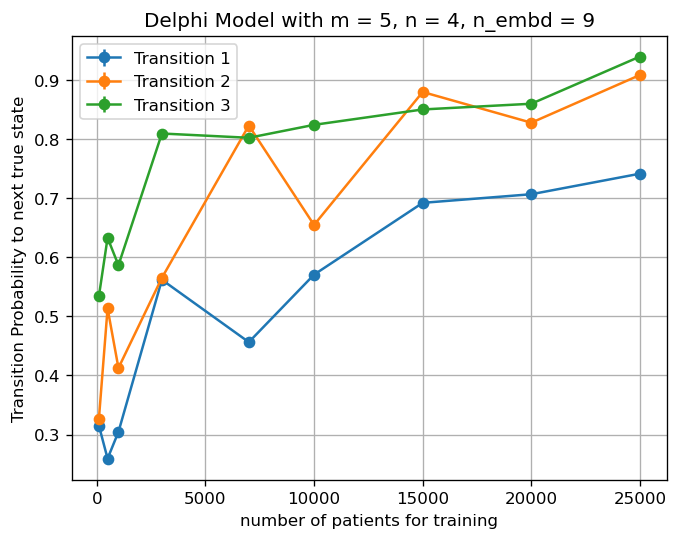

In [58]:
# Plot der Übergangswahrscheinlichkeiten
plt.figure(dpi = 120)
for transition in range(n - 1):
    label = "Transition " + str(transition + 1)
    plt.errorbar(n_samples, p[:,transition], yerr=dp[:,transition], label=label, marker="o")

plt.legend()
plt.xlabel("number of patients for training")
plt.ylabel("Transition Probability to next true state")
plt.title("Delphi Model with m = " + str(m) + ", n = " + str(n) + ", n_embd = " + str(n + m))
plt.grid()

plt.savefig("Delphi_p_plot.png")
plt.show()

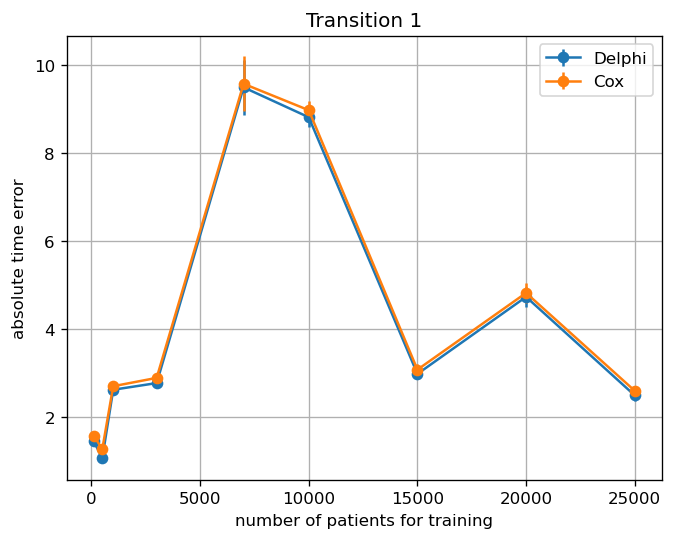

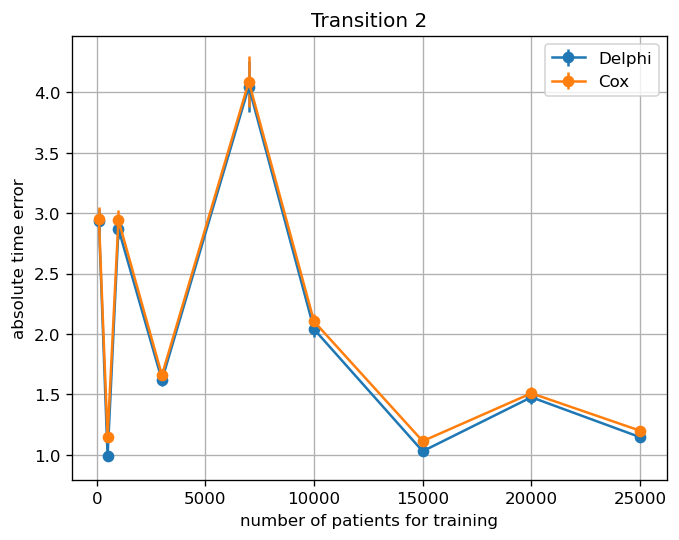

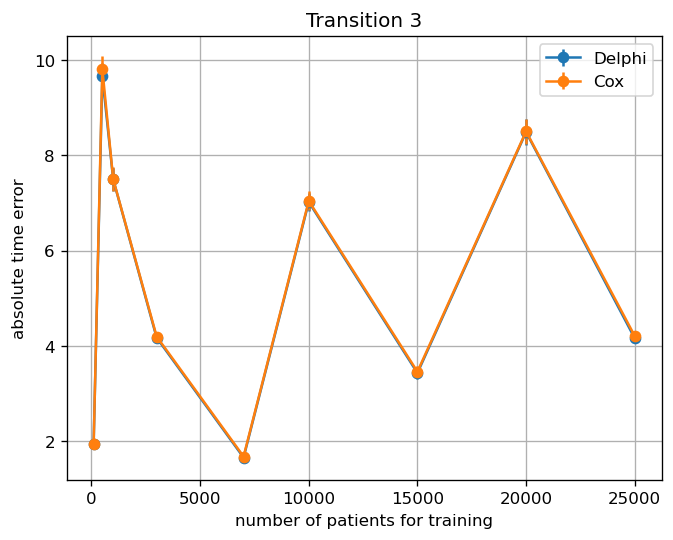

In [59]:
# Plot der Zeitfehler
for transition in range(n - 1):
    plt.figure(dpi = 120)
    title = "Transition " + str(transition + 1)
    filename = "Delphi_time_error_plot_transition_" + str(transition + 1) + ".png"
    plt.errorbar(n_samples, t[:,transition], yerr=dt[:,transition], label="Delphi", marker="o")
    plt.errorbar(n_samples, cox_t[:,transition], yerr=cox_dt[:,transition], label="Cox", marker="o")

    plt.legend()
    plt.xlabel("number of patients for training")
    plt.ylabel("absolute time error")
    plt.grid()
    plt.title(title)

    plt.savefig(filename)
    plt.show()

## Simulation 2: Variation der Embedding Dimension
In dieser Simulation soll der Einfluss der Embedding Dimension untersucht werden. Simuliert wurde hier ein Modell mit n = 4 Zuständen und m = 5 Covariaten. Trainiert wurde mit $\mu = 10^{-3}$ und einer Learning rate von $10^{-6}$. Die Auswertung erfolgt hier jeweils durch 3000 Patienten, mit welchen nicht trainiert wurde.

In [107]:
# Speichern der Daten
n_embd_values = np.array([3, 6, 9, 12, 15, 18])
n_samples = np.array([1600, 5000, 10000, 16500, 24800, 34800])
epochs = np.array([30, 20, 15, 15, 15, 10])

p = [
    [0.24461539, 0.28323907, 0.17374553],
    [0.31871864, 0.46592343, 0.5439187 ],
    [0.5703969, 0.6544434,  0.82366407],
    [0.7845049,  0.81496525, 0.91461205],
    [0.87766457, 0.9137653,  0.94195163],
    [0.84325397, 0.9392072,  0.95433974]
]

dp = [
    [0.00174213, 0.00117171, 0.00119183],
    [0.00181394, 0.00213843, 0.00194004],
    [0.00271867, 0.00205114, 0.00166761],
    [0.0030695,  0.00218327, 0.0010128 ],
    [0.00142962, 0.00033019, 0.00034367],
    [0.0017328,  0.00033888, 0.00027821]
]

t = [
    [9.302979, 4.511447, 1.406473],
    [9.244756,  2.865033,  1.8283887],
    [8.80687,   2.0396597, 7.0214205],
    [1.4936947, 9.831375,  1.6850929],
    [1.4190706, 5.8452864, 8.5697   ],
    [6.7704935, 2.4920564, 1.745594 ]
]

dt = [
    [0.2063457,  0.15694669, 0.0293004 ],
    [0.19593984, 0.10367859, 0.04819293],
    [0.21342613, 0.06109478, 0.1984999 ],
    [0.05200223, 0.28770334, 0.04129264],
    [0.04525249, 0.13623704, 0.18324365],
    [0.17358498, 0.08111891, 0.05686199]
]

cox_t = [
    [9.46219737, 4.82315022, 1.51139659],
    [9.37144724, 2.94685107, 1.84358959],
    [8.96712539, 2.10384631, 7.04454922],
    [1.61148843, 9.89171029, 1.72761395],
    [1.50231274, 5.88009589, 8.58278355],
    [6.87413774, 2.52316222, 1.76224177]
]

cox_dt = [
    [0.20629268, 0.15646632, 0.02951057],
    [0.19606483, 0.10345343, 0.04822371],
    [0.21349701, 0.06110446, 0.19846104],
    [0.05184043, 0.28753842, 0.04126379],
    [0.04507474, 0.13616253, 0.18322914],
    [0.17399003, 0.08115208, 0.05688312]
]

p = np.array(p)
dp = np.array(dp)
t = np.array(t)
dt = np.array(dt)
cox_t = np.array(cox_t)
cox_dt = np.array(cox_dt)

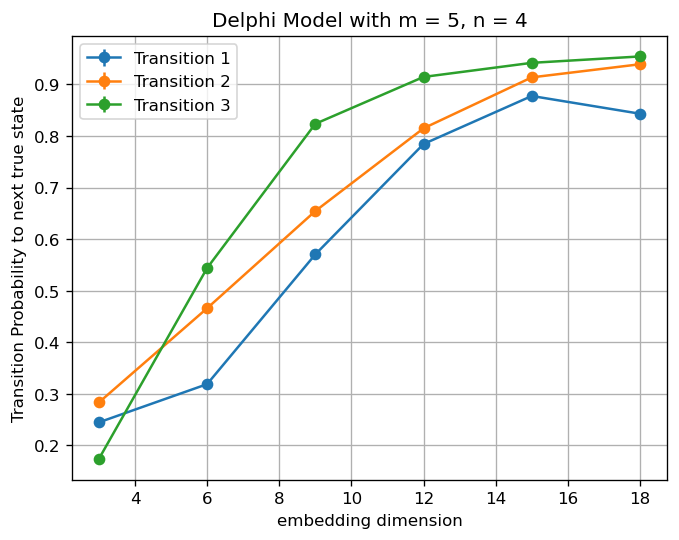

In [108]:
# Plot der Übergangswahrscheinlichkeiten
plt.figure(dpi = 120)
for transition in range(n - 1):
    label = "Transition " + str(transition + 1)
    plt.errorbar(n_embd_values, p[:,transition], yerr=dp[:,transition], label=label, marker="o")

plt.legend()
plt.xlabel("embedding dimension")
plt.ylabel("Transition Probability to next true state")
plt.title("Delphi Model with m = " + str(m) + ", n = " + str(n))
plt.grid()

plt.savefig("Delphi_p_plot_embedding.png")
plt.show()

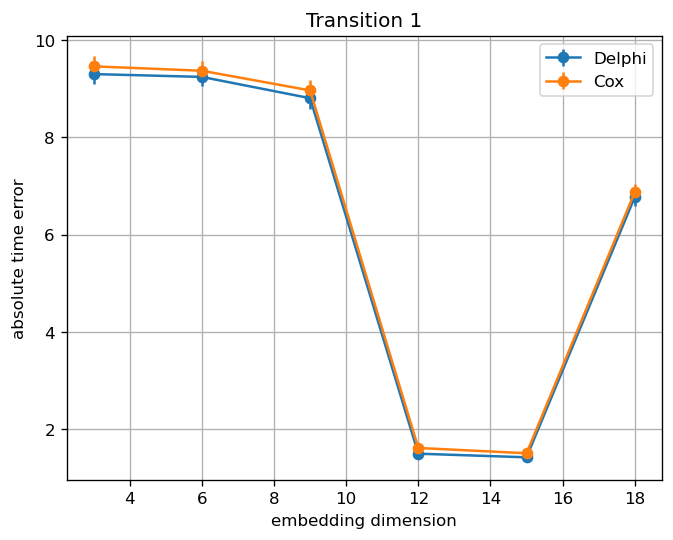

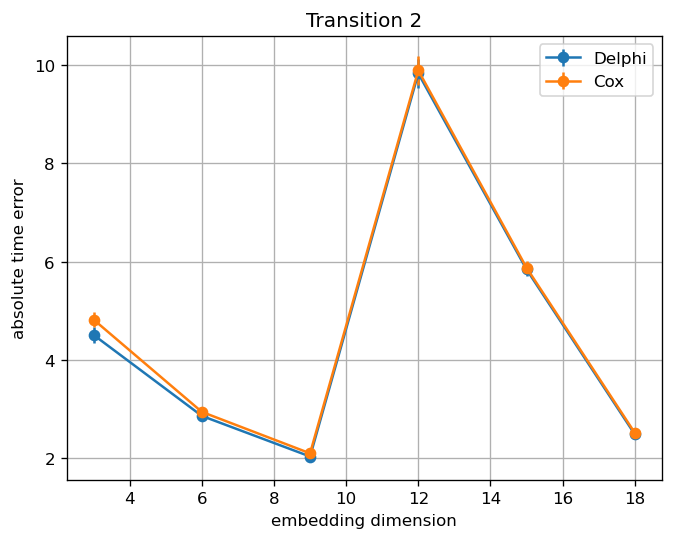

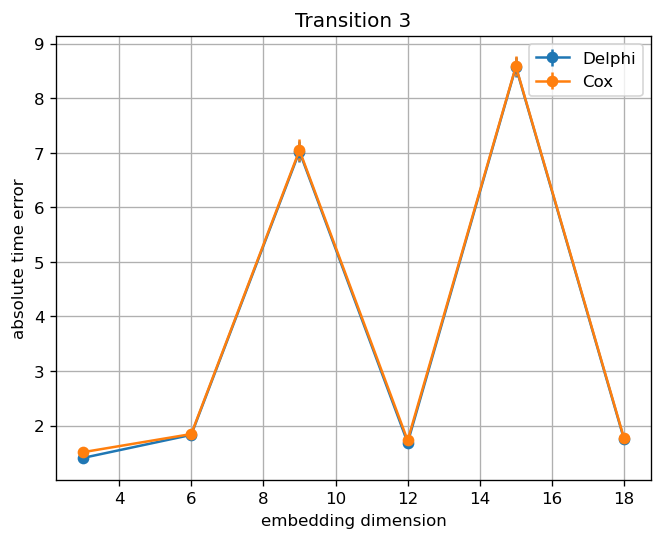

In [109]:
# Plot der Zeitfehler
for transition in range(n - 1):
    plt.figure(dpi = 120)
    title = "Transition " + str(transition + 1)
    filename = "Delphi_time_error_plot_transition_" + str(transition + 1) + "_embedding.png"
    plt.errorbar(n_embd_values, t[:,transition], yerr=dt[:,transition], label="Delphi", marker="o")
    plt.errorbar(n_embd_values, cox_t[:,transition], yerr=cox_dt[:,transition], label="Cox", marker="o")

    plt.legend()
    plt.xlabel("embedding dimension")
    plt.ylabel("absolute time error")
    plt.grid()
    plt.title(title)

    plt.savefig(filename)
    plt.show()